In [2]:
%load_ext autoreload
%autoreload 2

import requests
import torch
from torch.utils.data import DataLoader
import random
import torch.nn as nn 
from torch import optim
# from sklearn.decomposition import TruncatedSVD as svds
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from torch.nn.utils.rnn import pad_sequence
from spice import SpiceEmbeddingModel
from gru import GRUEncoder, GRUDecoder
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import re
import pickle
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from tpdn import TPDNEncoder

In [ ]:

URL = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
FILE_PATH = "shakespeare.txt"
EMB_DIM = 64
WINDOW = 5


try:
    with open(FILE_PATH, 'r', encoding='utf-8') as f:
        text = f.read()
except FileNotFoundError:
    response = requests.get(URL)
    text = response.text
    with open(FILE_PATH, 'w', encoding='utf-8') as f:
        f.write(text)


spice_model = SpiceEmbeddingModel(emb_dim=50, window_size=3)

sentences = spice_model.preprocess_text(text)
# print(sentences)


dataset = spice_model.get_dataset(text)
# spice_model.save_model(spice_model.embeddings)

# dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


# for batch in dataloader:
#     sentence_embeddings = batch
#     print("Sentence Embeddings: ", len(sentence_embeddings[0]))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_fn(batch):
    """ permet de rajouter du padding et renvoyer la taille de la séquence dans un batch"""
    batch = [item for item in batch if len(item) > 0]  # Filtrer les séquences vides
    lengths = torch.tensor([len(seq) for seq in batch])  # Longueurs originales
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=0.0)  # Padding des séquences
    return padded_batch, lengths


spice_model = SpiceEmbeddingModel()
spice_model.load_model()
dataset = spice_model.get_dataset(text)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)




In [ ]:
for batch in dataloader : 
    a, b = batch
    print( a.shape)


In [11]:


input_size = 50       # dim des fillers 
role_dim = 20         # dim  des vecteurs de rôle
hidden_size = 128     # dim de la représentation latente
lr = 0.001
num_layers = 3
num_epochs = 20
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class EmbeddingAndRoleDataset(Dataset):
    """
    Dataset qui renvoie pour chaque phrase un tuple (fillers, roles)
    - fillers : tenseur (seq_len, emb_dim) des embeddings de mots
    - roles   : tenseur (seq_len, role_dim) des vecteurs de rôle calculés par cosinus
    """
    def __init__(self, fillers_list, roles_list):
        self.fillers_list = fillers_list
        self.roles_list = roles_list

    def __len__(self):
        return len(self.fillers_list)

    def __getitem__(self, idx):
        return self.fillers_list[idx], self.roles_list[idx]

def positional_encoding(seq_len, role_dim, p):
    """
    encoding positionnel pour les rôles un peu comme dans les transformers
    """
    positions = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)  # (seq_len, 1)
    dims = torch.arange(role_dim, dtype=torch.float32).unsqueeze(0)         # (1, role_dim)
    pos_enc = torch.cos(2 * positions * dims / p)  # (seq_len, role_dim)
    return pos_enc

def collate_fn_fillers_roles(batch):
    """
    Collate function pour un batch de tuples (fillers, roles).
    Effectue le padding sur les fillers et les roles et renvoie aussi les longueurs.
    """
    fillers_list, roles_list = zip(*batch)
    lengths = torch.tensor([f.shape[0] for f in fillers_list], dtype=torch.long)
    padded_fillers = pad_sequence(fillers_list, batch_first=True, padding_value=0.0)
    padded_roles = pad_sequence(roles_list, batch_first=True, padding_value=0.0)
    return padded_fillers, padded_roles, lengths

class SpiceEmbeddingModel:
    def __init__(self, emb_dim=50, window_size=3):
        self.emb_dim = emb_dim
        self.window_size = window_size
        self.word2idx = {}
        self.idx2word = {}
        self.embeddings = None

    def preprocess_text(self, text):
        # On retire les lignes contenant ":" puis on met en minuscule et on garde uniquement les lettres et espaces
        sentences = text.split('\n')
        sentences = [lst for lst in sentences if ":" not in lst]
        text = '\n'.join(sentences).lower()
        text = re.sub(r"[^a-z\s]", "", text)
        sentences = [lst for lst in text.split('\n') if lst]
        return sentences

    def build_cooccurrence_matrix(self, words):
        # Si le vocabulaire est vide, on le construit à partir de tous les mots du texte
        if not self.word2idx:
            vocab = sorted(set(words))
            self.word2idx = {word: idx for idx, word in enumerate(vocab)}
            self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        vocab_size = len(self.word2idx)
        co_matrix = np.zeros((vocab_size, vocab_size))
        for i, word in enumerate(words):
            # Si le mot n'est pas dans le vocabulaire (cas d'un modèle pré-chargé avec un vocabulaire différent),
            # on passe au mot suivant
            if word not in self.word2idx:
                continue
            word_idx = self.word2idx[word]
            start, end = max(0, i - self.window_size), min(len(words), i + self.window_size + 1)
            for j in range(start, end):
                # On vérifie également que le mot voisin est dans le vocabulaire
                if i != j and words[j] in self.word2idx:
                    neighbor_idx = self.word2idx[words[j]]
                    co_matrix[word_idx, neighbor_idx] += 1
        return co_matrix

    def spice_embedding(self, co_matrix):
        # On utilise une décomposition SVD pour obtenir des embeddings de dimension emb_dim
        u, s, vt = svds(co_matrix, k=self.emb_dim)
        embeddings = normalize(u @ np.diag(np.sqrt(s)))
        return embeddings

    def save_model(self):
        with open("spice_embeddings.pkl", "wb") as f:
            pickle.dump(self.embeddings, f)
        with open("spice_vocab.pkl", "wb") as f:
            pickle.dump(self.word2idx, f)

    def load_model(self):
        with open("spice_embeddings.pkl", "rb") as f:
            self.embeddings = pickle.load(f)
        with open("spice_vocab.pkl", "rb") as f:
            self.word2idx = pickle.load(f)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode_word(self, word):
        return self.embeddings[self.word2idx[word]] if word in self.word2idx else None

    def decode_embedding(self, vector, top_n=5):
        similarities = np.dot(self.embeddings, vector)
        closest_indices = np.argsort(similarities)[-top_n:][::-1]
        return [self.idx2word[idx] for idx in closest_indices]

    def get_dataset(self, text, role_dim=20):
        """
        Pour un texte en entrée, on :
         - pré-traite pour obtenir des phrases
         - crée les embeddings (fillers) via SVD sur la matrice de cooccurrence
         - pour chaque phrase, on récupère les fillers et on calcule les rôles
           (les rôles sont calculés avec la fonction cosinus en fonction de la position)
         - on renvoie un EmbeddingAndRoleDataset
        """
        sentences = self.preprocess_text(text)
        words = [word for sentence in sentences for word in sentence.split()]
        co_matrix = self.build_cooccurrence_matrix(words)
        self.embeddings = self.spice_embedding(co_matrix)
        self.save_model()

        # Déterminer la longueur maximale (pour fixer l'échelle p)
        max_seq_len = max(len(sentence.split()) for sentence in sentences)

        fillers_list = []
        roles_list = []
        for sentence in sentences:
            tokens = sentence.split()
            if not tokens:
                continue
            # Récupérer les fillers (embeddings) pour chaque mot de la phrase
            sentence_fillers = []
            for word in tokens:
                if word in self.word2idx:
                    emb = self.embeddings[self.word2idx[word]]
                    sentence_fillers.append(torch.tensor(emb, dtype=torch.float32))
            if len(sentence_fillers) == 0:
                continue
            sentence_fillers = torch.stack(sentence_fillers)  # (seq_len, emb_dim)
            fillers_list.append(sentence_fillers)
            # Calculer les rôles via un positional encoding simple
            seq_len = sentence_fillers.size(0)
            sentence_roles = positional_encoding(seq_len, role_dim, p=max_seq_len)
            roles_list.append(sentence_roles)

        return EmbeddingAndRoleDataset(fillers_list, roles_list)



# Charger ou créer les embeddings Spice
spice_model = SpiceEmbeddingModel()
# Si les fichiers existent déjà, on peut charger le modèle ; sinon, on le crée.
try:
    spice_model.load_model()
except Exception as e:
    print("No pre-saved model found, building a new one.")


dataset = spice_model.get_dataset(text, role_dim=role_dim)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_fillers_roles)



In [19]:
for batch in dataloader :
    a, b ,c = batch
    print(a.shape)
    print( b.shape)
    print( c)
    break

torch.Size([64, 12, 50])
torch.Size([64, 12, 20])
tensor([ 8,  8,  7,  5, 10, 10, 10,  8, 10,  8,  7, 12, 10,  9,  9,  7,  7,  9,
         7,  9,  2,  9,  8,  6,  4,  8,  7,  6,  1,  9,  9,  5,  7,  9,  9,  8,
         3,  7, 10,  8,  8,  7,  7,  9,  9,  7,  8,  3,  9, 10,  5,  9,  4,  9,
         7,  3,  8,  9,  1, 10,  7,  8,  8,  6])


Epoch 1/50, Loss: 0.057155295497399165
Epoch 2/50, Loss: 0.0531491037691012
Epoch 3/50, Loss: 0.052890781038017434
Epoch 4/50, Loss: 0.052709314093755726
Epoch 5/50, Loss: 0.0525663172275844
Epoch 6/50, Loss: 0.05243275504008951
Epoch 7/50, Loss: 0.05238066064405509
Epoch 8/50, Loss: 0.052321543557230725
Epoch 9/50, Loss: 0.052307751273143695
Epoch 10/50, Loss: 0.0523074267601425
Epoch 11/50, Loss: 0.05230459542310035
Epoch 12/50, Loss: 0.052241656093180856
Epoch 13/50, Loss: 0.05224432823756202
Epoch 14/50, Loss: 0.052285027764314276
Epoch 15/50, Loss: 0.05229660881344567
Epoch 16/50, Loss: 0.05230472205122086
Epoch 17/50, Loss: 0.052201796799305485
Epoch 18/50, Loss: 0.052259654865007506
Epoch 19/50, Loss: 0.05231158049057492
Epoch 20/50, Loss: 0.052238164765929636
Epoch 21/50, Loss: 0.05226744438352233
Epoch 22/50, Loss: 0.05221764287191697
Epoch 23/50, Loss: 0.052296718921173706
Epoch 24/50, Loss: 0.05226257280446589
Epoch 25/50, Loss: 0.05224151543172246
Epoch 26/50, Loss: 0.05227

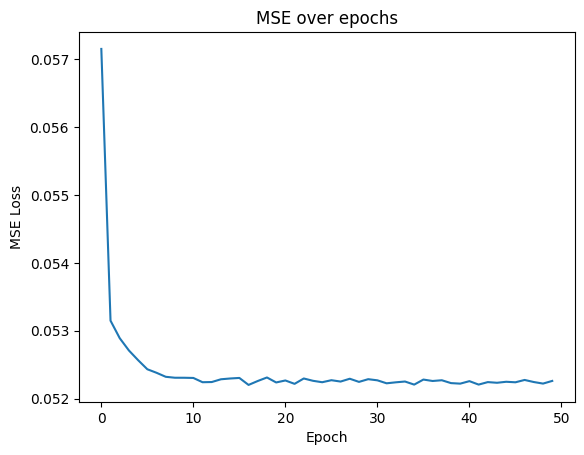

In [25]:


input_size = 50       # dim des fillers 
role_dim = 20         # dim  des vecteurs de rôle
hidden_size = 128     # dim de la représentation latente
lr = 0.001
num_layers = 3
num_epochs = 50
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



class EmbeddingAndRoleDataset(Dataset):
    """
    Dataset qui renvoie pour chaque phrase un tuple (fillers, roles)
    - fillers : tenseur (seq_len, emb_dim) des embeddings de mots
    - roles   : tenseur (seq_len, role_dim) des vecteurs de rôle calculés par cosinus
    """
    def __init__(self, fillers_list, roles_list):
        self.fillers_list = fillers_list
        self.roles_list = roles_list

    def __len__(self):
        return len(self.fillers_list)

    def __getitem__(self, idx):
        return self.fillers_list[idx], self.roles_list[idx]

def positional_encoding(seq_len, role_dim, p):
    """
    encoding positionnel pour les rôles un peu comme dans les transformers
    """
    positions = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)  # (seq_len, 1)
    dims = torch.arange(role_dim, dtype=torch.float32).unsqueeze(0)         # (1, role_dim)
    pos_enc = torch.cos(2 * positions * dims / p)  # (seq_len, role_dim)
    return pos_enc

def collate_fn_fillers_roles(batch):
    """
    Collate function pour un batch de tuples (fillers, roles).
    Effectue le padding sur les fillers et les roles et renvoie aussi les longueurs.
    """
    fillers_list, roles_list = zip(*batch)
    lengths = torch.tensor([f.shape[0] for f in fillers_list], dtype=torch.long)
    padded_fillers = pad_sequence(fillers_list, batch_first=True, padding_value=0.0)
    padded_roles = pad_sequence(roles_list, batch_first=True, padding_value=0.0)
    return padded_fillers, padded_roles, lengths

class SpiceEmbeddingModel:
    def __init__(self, emb_dim=50, window_size=3):
        self.emb_dim = emb_dim
        self.window_size = window_size
        self.word2idx = {}
        self.idx2word = {}
        self.embeddings = None

    def preprocess_text(self, text):
        # On retire les lignes contenant ":" puis on met en minuscule et on garde uniquement les lettres et espaces
        sentences = text.split('\n')
        sentences = [lst for lst in sentences if ":" not in lst]
        text = '\n'.join(sentences).lower()
        text = re.sub(r"[^a-z\s]", "", text)
        sentences = [lst for lst in text.split('\n') if lst]
        return sentences

    def build_cooccurrence_matrix(self, words):
        # Si le vocabulaire est vide, on le construit à partir de tous les mots du texte
        if not self.word2idx:
            vocab = sorted(set(words))
            self.word2idx = {word: idx for idx, word in enumerate(vocab)}
            self.idx2word = {idx: word for word, idx in self.word2idx.items()}

        vocab_size = len(self.word2idx)
        co_matrix = np.zeros((vocab_size, vocab_size))
        for i, word in enumerate(words):
            # Si le mot n'est pas dans le vocabulaire (cas d'un modèle pré-chargé avec un vocabulaire différent),
            # on passe au mot suivant
            if word not in self.word2idx:
                continue
            word_idx = self.word2idx[word]
            start, end = max(0, i - self.window_size), min(len(words), i + self.window_size + 1)
            for j in range(start, end):
                # On vérifie également que le mot voisin est dans le vocabulaire
                if i != j and words[j] in self.word2idx:
                    neighbor_idx = self.word2idx[words[j]]
                    co_matrix[word_idx, neighbor_idx] += 1
        return co_matrix

    def spice_embedding(self, co_matrix):
        # On utilise une décomposition SVD pour obtenir des embeddings de dimension emb_dim
        u, s, vt = svds(co_matrix, k=self.emb_dim)
        embeddings = normalize(u @ np.diag(np.sqrt(s)))
        return embeddings

    def save_model(self):
        with open("spice_embeddings.pkl", "wb") as f:
            pickle.dump(self.embeddings, f)
        with open("spice_vocab.pkl", "wb") as f:
            pickle.dump(self.word2idx, f)

    def load_model(self):
        with open("spice_embeddings.pkl", "rb") as f:
            self.embeddings = pickle.load(f)
        with open("spice_vocab.pkl", "rb") as f:
            self.word2idx = pickle.load(f)
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}

    def encode_word(self, word):
        return self.embeddings[self.word2idx[word]] if word in self.word2idx else None

    def decode_embedding(self, vector, top_n=5):
        similarities = np.dot(self.embeddings, vector)
        closest_indices = np.argsort(similarities)[-top_n:][::-1]
        return [self.idx2word[idx] for idx in closest_indices]

    def get_dataset(self, text, role_dim=20):
        """
        Pour un texte en entrée, on :
         - pré-traite pour obtenir des phrases
         - crée les embeddings (fillers) via SVD sur la matrice de cooccurrence
         - pour chaque phrase, on récupère les fillers et on calcule les rôles
           (les rôles sont calculés avec la fonction cosinus en fonction de la position)
         - on renvoie un EmbeddingAndRoleDataset
        """
        sentences = self.preprocess_text(text)
        words = [word for sentence in sentences for word in sentence.split()]
        co_matrix = self.build_cooccurrence_matrix(words)
        self.embeddings = self.spice_embedding(co_matrix)
        self.save_model()

        # Déterminer la longueur maximale (pour fixer l'échelle p)
        max_seq_len = max(len(sentence.split()) for sentence in sentences)

        fillers_list = []
        roles_list = []
        for sentence in sentences:
            tokens = sentence.split()
            if not tokens:
                continue
            # Récupérer les fillers (embeddings) pour chaque mot de la phrase
            sentence_fillers = []
            for word in tokens:
                if word in self.word2idx:
                    emb = self.embeddings[self.word2idx[word]]
                    sentence_fillers.append(torch.tensor(emb, dtype=torch.float32))
            if len(sentence_fillers) == 0:
                continue
            sentence_fillers = torch.stack(sentence_fillers)  # (seq_len, emb_dim)
            fillers_list.append(sentence_fillers)
            # Calculer les rôles via un positional encoding simple
            seq_len = sentence_fillers.size(0)
            sentence_roles = positional_encoding(seq_len, role_dim, p=max_seq_len)
            roles_list.append(sentence_roles)

        return EmbeddingAndRoleDataset(fillers_list, roles_list)




spice_model = SpiceEmbeddingModel()

try:
    spice_model.load_model()
except Exception as e:
    print("No pre-saved model found, building a new one.")


dataset = spice_model.get_dataset(text, role_dim=role_dim)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_fillers_roles)


encoder_rnn = torch.load("encoder.pth", weights_only=False).to(device)

tpdn_encoder = TPDNEncoder(input_size, role_dim, hidden_size).to(device)
# decoder = GRUDecoder(hidden_size, input_size, num_layers).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(list(tpdn_encoder.parameters()),lr=lr)
encoder_rnn.eval()
tpdn_encoder.train()
losses = []
for epoch in range(num_epochs):
    total_loss = 0.0
    for fillers, roles, lengths in dataloader:
        fillers = fillers.to(device)  # (batch, seq_len, input_size)
        roles = roles.to(device)        # (batch, seq_len, role_dim)
        lengths = lengths.to(device)    # (batch,)
        optimizer.zero_grad()

        encoded_tpdn = tpdn_encoder(fillers, roles, lengths)  # (batch, hidden_size)
        # reconstructed = decoder(encoded, lengths)         # (batch, max_seq_len, input_size)
        with torch.no_grad():
            encoded_rnn, _ = encoder_rnn(fillers, lengths)
        # assure que fillers et reconstructed ont la même taille pour le calcul de la loss
        # max_seq_len_batch = reconstructed.size(1)
        # if fillers.size(1) < max_seq_len_batch:
        #     pad_size = max_seq_len_batch - fillers.size(1)
        #     fillers = torch.nn.functional.pad(fillers, (0, 0, 0, pad_size), "constant", 0.0)
        
        loss = criterion(encoded_tpdn, encoded_rnn)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")


torch.save(tpdn_encoder, "tpdn_encoder.pth")



plt.plot(losses)
plt.title("MSE over epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()
